# Context

in this notebook we are trying to optimise the best model form the selection phase to better target each different phylum. In that sense we are splitting the training and the modeling for the different phylumns  

# Imports

In [4]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/rare_species 1.zip'
extract_path = '/content/rare_species 1'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow import data as tf_data
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Rescaling, RandAugment

from sklearn.metrics import classification_report

In [9]:
# Set the correct folder and metadata paths
folder_path = '/content/rare_species 1'
meta = pd.read_csv('/content/rare_species 1/metadata.csv')

# With vscode
# folder_path = '../data/rare_species 1'
# meta = pd.read_csv('../data/rare_species 1/metadata.csv')

In [10]:
print(f"the diferent Phylum are: \n{meta['phylum'].unique()}")
print(f"each phylum contains :  \n{meta['phylum'].value_counts()}")

print(f"their is {meta['family'].nunique()} different families")

meta

the diferent Phylum are: 
['mollusca' 'chordata' 'arthropoda' 'echinodermata' 'cnidaria']
each phylum contains :  
phylum
chordata         9952
arthropoda        951
cnidaria          810
mollusca          210
echinodermata      60
Name: count, dtype: int64
their is 202 different families


rare_species_id  eol_content_id  eol_page_id  \
0      75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1      28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2      00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3      29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4      94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   
...                                     ...             ...          ...   
11978  1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89        29734618      1011315   
11979  628bf2b4-6ecc-4017-a8e6-4306849e0cfc        29972861      1056842   
11980  0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9        30134195     52572074   
11981  27fdb1e9-c5fb-459a-8b6a-6fb222b1c512         9474963     46559139   
11982  54894a59-151f-4814-ac32-3a336841e58e         9465817       326525   

        kingdom    phylum            family  \
0      animalia  mollusca         unionidae   
1      animalia  chordata       geoemydidae   
2      animalia  chordata  cryptobranchidae   
3      animalia  chordata          turdidae   
4      animalia  chordata         indriidae   
...         ...       ...               ...   
11978  animalia  chordata         leporidae   
11979  animalia  chordata          emydidae   
11980  animalia  chordata        dasyatidae   
11981  animalia  chordata        mustelidae   
11982  animalia  chordata         lemuridae   

                                               file_path  
0      mollusca_unionidae/12853737_449393_eol-full-si...  
1      chordata_geoemydidae/20969394_793083_eol-full-...  
2      chordata_cryptobranchidae/28895411_319982_eol-...  
3      chordata_turdidae/29658536_45510188_eol-full-s...  
4      chordata_indriidae/21252576_7250886_eol-full-s...  
...                                                  ...  
11978  chordata_leporidae/29734618_1011315_eol-full-s...  
11979  chordata_emydidae/29972861_1056842_eol-full-si...  
11980  chordata_dasyatidae/30134195_52572074_eol-full...  
11981  chordata_mustelidae/9474963_46559139_eol-full-...  
11982  chordata_lemuridae/9465817_326525_eol-full-siz...  

[11983 rows x 7 columns]

# Phylum Splits

This code splits the species into separate folders based on their phylum.  
This organization allows us to train a dedicated model for each phylum more effectively.<br>
(we repeat this proses in each notebook only because we are using colab)

In [17]:
# Reload metadata to be sure
meta = pd.read_csv('/content/rare_species 1/metadata.csv')

# Filter only for mollusca
mollusca_meta = meta[meta['phylum'].str.lower() == 'mollusca']

source_root = "/content/rare_species 1"
destination_root = "/content/mollusca"

for _, row in mollusca_meta.iterrows():
    file_path = row['file_path']
    family = row['family']

    # full source path
    source_path = os.path.join(source_root, file_path)

    # full destination folder path
    dest_folder = os.path.join(destination_root, f"mollusca_{family}")
    os.makedirs(dest_folder, exist_ok=True)

    # destination path
    dest_path = os.path.join(dest_folder, os.path.basename(file_path))

    # Copy if file exists
    if os.path.exists(source_path):
        shutil.copy2(source_path, dest_path)
    else:
        print(f" Missing file: {source_path}")

# Train Val Split

In [21]:
# with colab
path_phylum_mollusca = "/content/mollusca"


# with vscode
# path_phylum_chordata = "../data/chordata"


image_size = (224, 224)
seed = 42
batch_size = 32


train_ds_mollusca, val_ds_mollusca = keras.utils.image_dataset_from_directory(
    path_phylum_mollusca,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)


Found 210 files belonging to 5 classes.
Using 168 files for training.
Using 42 files for validation.


In [24]:
class_names = train_ds_mollusca.class_names
print("Mollusca families (classes):", class_names)

Mollusca families (classes): ['mollusca_cardiidae', 'mollusca_conidae', 'mollusca_haliotidae', 'mollusca_unionidae', 'mollusca_zonitidae']


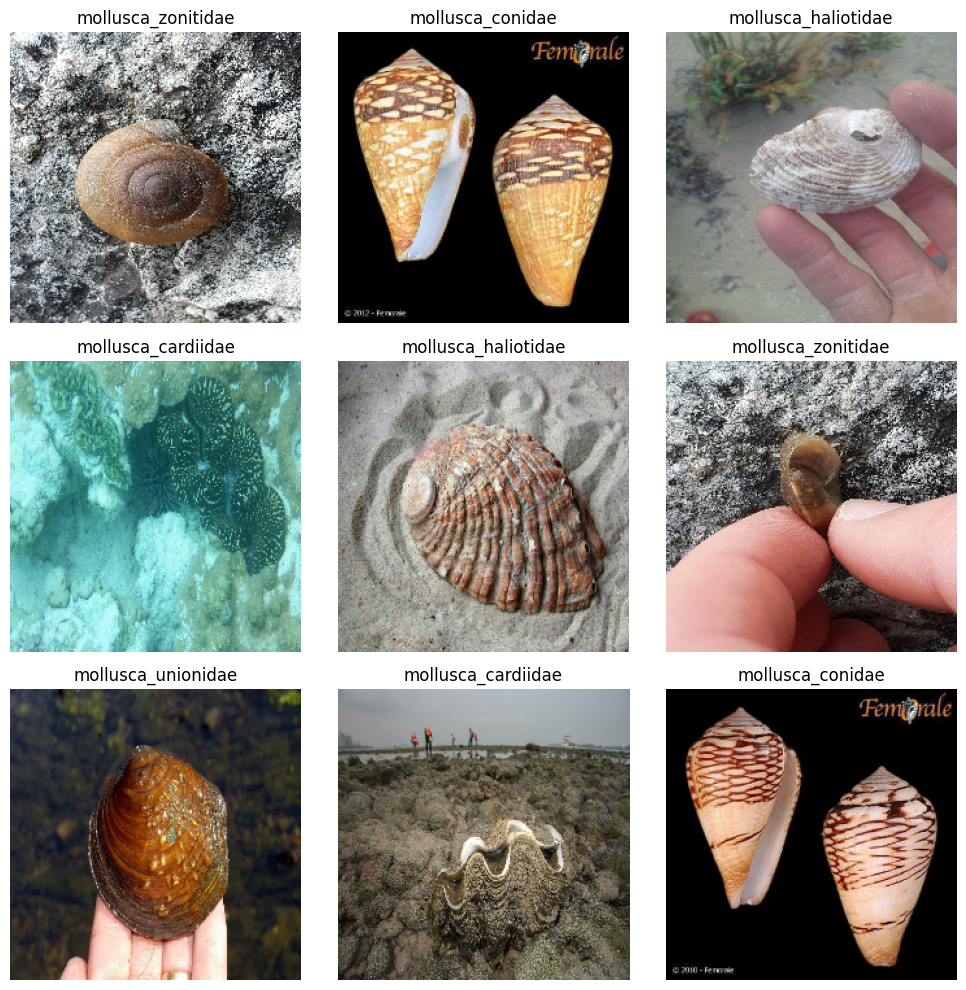

In [26]:
def display_images(train_ds):
    for images, labels in train_ds.take(1):
        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
        plt.tight_layout()
        plt.show()

display_images(train_ds_mollusca)

# Augmentation layer

In [29]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [30]:
data_augmentation_layers = [
    RandAugment(value_range= (0, 255))
    # More augemntation like number of times and or maginitude.
    # Default N-layers is 2 and default magintiude is 5
 ## add any you want here
]

# Model

In [39]:
def make_model_mobilenetv2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Apply data augmentation
    x = data_augmentation(inputs)  #

    # Normalize pixel values
    x = Rescaling(1./255)(x)

    # Pretrained MobileNetV2 base (frozen)
    base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")
    base_model.trainable = False # Freeze for transfer learning

    # Flatten instead of pooling (as required)
    x = base_model.output
    x = layers.Flatten()(x)               # GlobalAveragePooling2D
    x = layers.Dropout(0.1)(x)      # Optional regularization, change, it randomly sets eurons to 0 to reduce overfitting. so 0.1 is 10% of neurons are of.

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

<ipython-input-39-0ee61f10c504>:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=x, weights="imagenet")


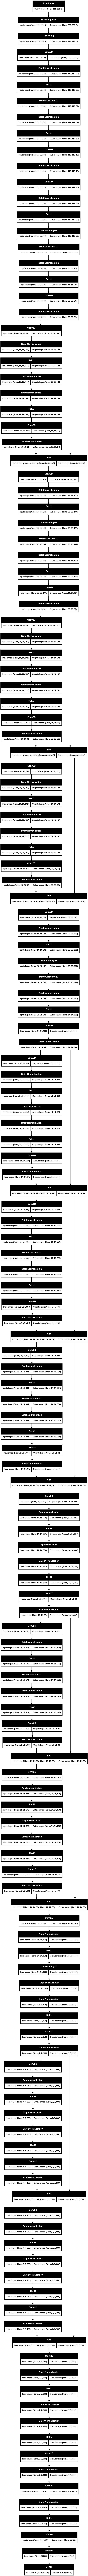

In [40]:
model_mollusca = make_model_mobilenetv2(input_shape=image_size + (3,), num_classes=len(train_ds_mollusca.class_names))
keras.utils.plot_model(model_mollusca, show_shapes=True)

# Run and evaluation

In [41]:
# Set number of training epochs
epochs = 20

# Learning rate scheduler to gradually decay learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9
)

# Callback to save the best model based on validation accuracy
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_mollusca.keras",  # ✅ Updated file name
        save_best_only=True,
        monitor="val_acc",            # ✅ Metric matches the one in compile
        mode="max",
        verbose=1
    )
]

# ✅ Compile the model
model_mollusca.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

# ✅ Train the model
history = model_mollusca.fit(
    train_ds_mollusca,
    validation_data=val_ds_mollusca,
    epochs=epochs,
    callbacks=callbacks
)

# Load best model
model = keras.models.load_model("best_model_mollusca.keras")

# Predict on validation set
y_pred_probs = model.predict(val_ds_mollusca)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in val_ds_mollusca], axis=0)

# Print report with readable family names (optional but helpful)
print(classification_report(y_true, y_pred, target_names=val_ds_mollusca.class_names))

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.3197 - loss: 2.8729
Epoch 1: val_acc improved from -inf to 0.52381, saving model to best_model_mollusca.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - acc: 0.3344 - loss: 2.8234 - val_acc: 0.5238 - val_loss: 1.9423
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.7421 - loss: 1.1739

KeyboardInterrupt: 